# Import and Installation and setup

In [1]:
# ! pip install torch torchvision matplotlib numpy

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import os

In [3]:
BASE_PATH = "question4"
SEED = 2

if not os.path.exists(BASE_PATH):
    os.mkdir(BASE_PATH)
    print(f"Path ::[{BASE_PATH}]:: Created!")

# MNIST dataset

## Load MNIST dataset

We normalize dataset with Min-Max Normalizer during loading dataset using transform

In [4]:
scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    scale
])

train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

print(f"Number of Train samples: {len(train_set)}")
print(f"Number of Test samples: {len(test_set)}")


Number of Train samples: 60000
Number of Test samples: 10000


## Explore MNIST dataset

In [5]:
def plot_samples(dataset, split, seed):
    np.random.seed(seed)
    print(f"MNIST Train Split Samples (seed = {seed}, {split} split)")

    plt.figure(figsize=(10, 5))

    found_samples = {i: False for i in range(10)}

    while not all(found_samples.values()):
        idx = np.random.randint(0, len(dataset))
        image , label = dataset[idx]
        if not found_samples[label]:
            # Plot the image
            plt.subplot(2, 5, label + 1)
            plt.imshow(image.squeeze(), cmap='gray')
            plt.title(f'Label: {label}')
            plt.axis('off')
            found_samples[label] = True

    # Show the plot
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, "MNIST_samples_" + split + ".png"))
    plt.show()



In [6]:
def plot_label_distribution_histogram(dataset, split):
    labels = [label for _, label in dataset]

    counts = [labels.count(i) for i in range(10)]

    fig, ax = plt.subplots()
    ax.bar(range(10), counts)

    for i in range(10):
        ax.text(i, counts[i], f"{100*(counts[i]/sum(counts)):.1f} %", ha="center", va="bottom")

    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_xticks(range(10))
    ax.set_xticklabels(range(10), ha="center")
    ax.set_title(f"Histogram of labels distribution for {split} split")
    plt.tight_layout()
    plt.savefig(os.path.join(BASE_PATH, "MNIST_labels_distribution_" + split + ".png"))
    plt.show()


### Plot a sample for each label of test and train splits

MNIST Train Split Samples (seed = 2, train split)


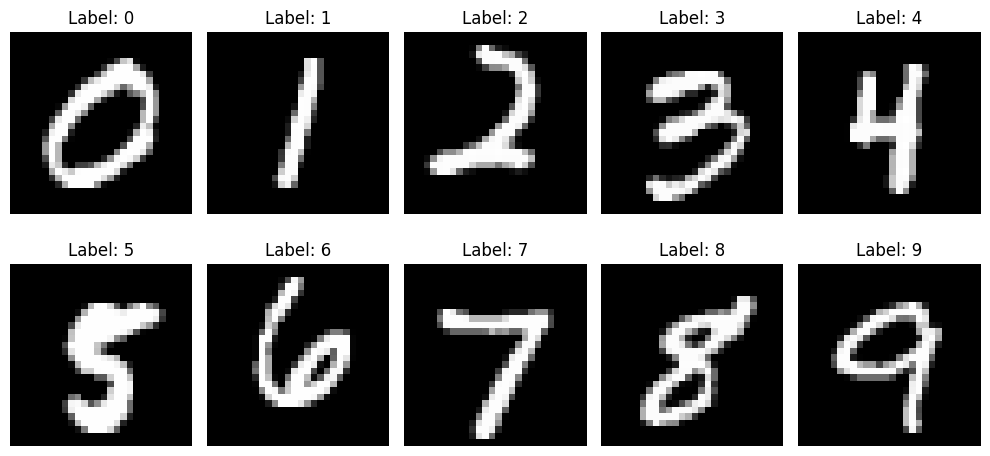

In [7]:
plot_samples(train_set, "train", SEED)

MNIST Train Split Samples (seed = 2, test split)


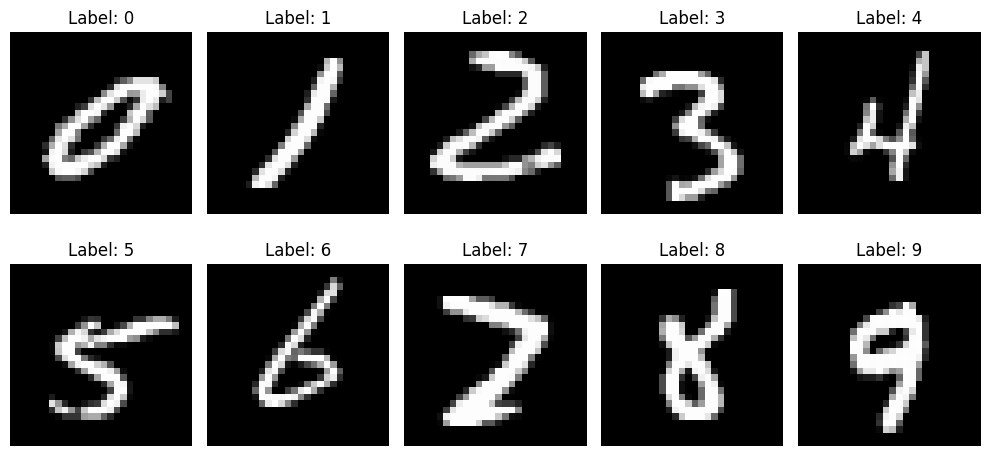

In [8]:
plot_samples(test_set, "test", SEED)

### Plot labels distribution

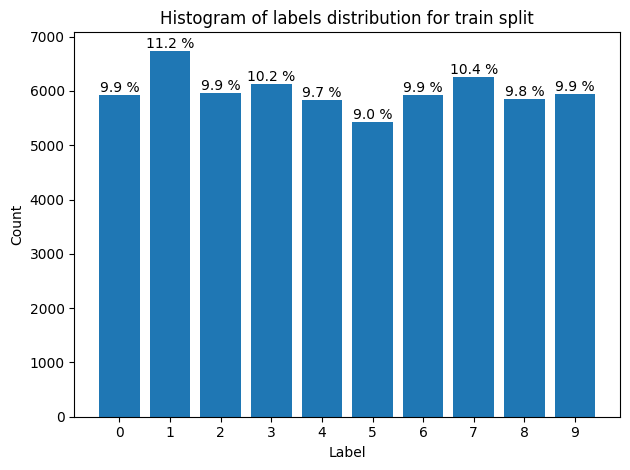

In [9]:
plot_label_distribution_histogram(train_set, "train")


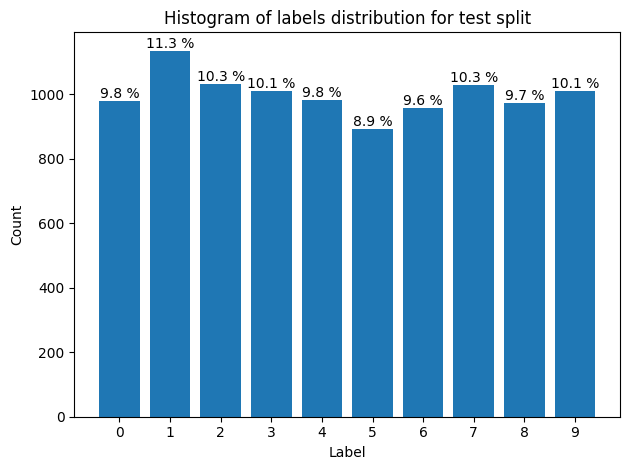

In [10]:
plot_label_distribution_histogram(test_set, "test")


### Min-Max Normalization

Note then we normalized dataset while loading it, if you don't want to do both at the same time, you can use code below, but we suggest our approach for this purpose.

In [11]:
# scale = torchvision.transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
# train_set.data = scale(train_set.data)
# test_set.data = scale(test_set.data)


In [12]:
# print(f"Train set: min = {train_set.data.min().item():.3f}, max = {train_set.data.max().item():.3f}")
# print(f"Test set: min = {test_set.data.min().item():.3f}, max = {test_set.data.max().item():.3f}")

# Generate model classes and Train them

In [13]:
@torch.no_grad()
def model_eval(
        model,
        device,
        data_loader,
):
    test_loss = 0.0
    test_correct = 0
    model = model.to(device)
    loss_function = nn.CrossEntropyLoss()

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_function(outputs, labels)

        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels).item()

    test_loss = test_loss / len(data_loader)
    test_acc = test_correct / len(test_set)

    return test_loss, test_acc

def train_model(
        model,
        batch_size,
        loss_function,
        optimizer_gen,
        learning_rate,
        epochs,
        train_set,
        test_set,
        triple_format=False
):
    optimizer = optimizer_gen(params=model.parameters(), lr=learning_rate)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_loss_list = []
    train_acc_list = []

    test_loss_list = []
    test_acc_list = []

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    model = model.to(device)

    for epoch in range(epochs):
        model.train()

        train_loss = 0.0
        train_correct = 0

        if triple_format:
            for inputs, labels, target in train_loader:
                inputs = inputs.to(device)
                target = target.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                loss.backward()
                optimizer.step()


                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == target).item()
        else:
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                loss.backward()
                optimizer.step()


                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += torch.sum(preds == labels).item()

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / len(train_set)

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        model.eval()

        test_loss, test_acc = model_eval(
            model=model,
            device=device,
            data_loader=test_loader,
        )

        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)


        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {100*test_acc:.2f}%')

    history = {
        "train loss" : train_loss_list,
        "train acc" : train_acc_list,
        "test loss" : test_loss_list,
        "test acc" : test_acc_list,
    }

    return history


In [14]:
def plot_train_history(history):
    train_loss_list = history["train loss"]
    train_acc_list = history["train acc"]
    test_loss_list = history["test loss"]
    test_acc_list = history["test acc"]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss_list)+1), train_loss_list, label='Train Loss')
    plt.plot(range(1, len(test_loss_list)+1), test_loss_list, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Model Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label='Train Acc')
    plt.plot(range(1, len(test_acc_list)+1), test_acc_list, label='Test Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Model Accuracy")
    plt.legend()
    plt.show()


## Teacher Network

### Training config

In [15]:
T_LearningRare = 1e-2
T_BATCH_SIZE = 32
T_EPOCHS = 20

T_LOSS_F = nn.CrossEntropyLoss()
T_Optimizer_GEN = torch.optim.SGD

### Define model class

In [16]:
class Teacher(nn.Module):
    def __init__(self):
        super(Teacher, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(784, 1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, x):
        logits = self.network(x)
        return logits



### Train Teacher Model

In [17]:
model_path = os.path.join(BASE_PATH, "teacher_model.pth")
history_path = os.path.join(BASE_PATH, "teacher_history.npy")
teacher = Teacher()
need_training = True

if os.path.exists(model_path) and os.path.exists(history_path):
    print(f"Loading model from {model_path}")
    teacher.load_state_dict(torch.load(model_path))
    history = np.load(history_path, allow_pickle=True).item()
    need_training = False

Loading model from question4/teacher_model.pth


In [18]:
if need_training:
    history = train_model(
        model=teacher,
        batch_size=T_BATCH_SIZE,
        loss_function=T_LOSS_F,
        optimizer_gen=T_Optimizer_GEN,
        learning_rate=T_LearningRare,
        epochs=T_EPOCHS,
        train_set=train_set,
        test_set=test_set,
    )

    torch.save(teacher.state_dict(), model_path)
    np.save(history_path, history, allow_pickle=True)
else:
    print(f"Model has been trained already!")

Model has been trained already!


Notice: Model hasn't trained in this session!


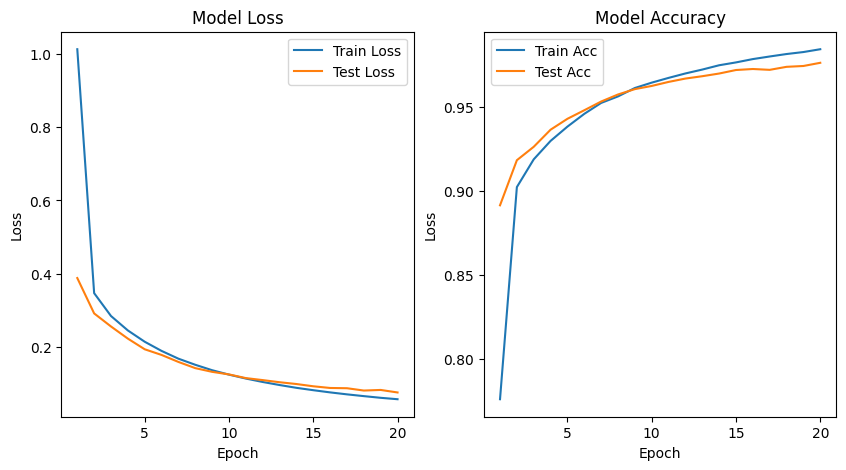

In [19]:
if not need_training:
    print("Notice: Model hasn't trained in this session!")

plot_train_history(history)

### How to find predicted label from logits?

Use argmax function

In [20]:
@torch.no_grad()
def pred_random_sample(model, dataset):
    idx = np.random.randint(0, len(dataset))
    image, label = dataset[idx]

    logits = model(image)
    pred = np.argmax(logits.detach().numpy())

    print(f"Predicted label: {pred}, True label: {label}")

    plt.figure(figsize=(4, 3))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Predicted label: 5, True label: 5


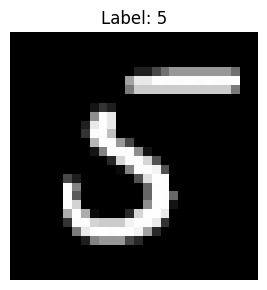

In [21]:
pred_random_sample(
    model=teacher,
    dataset=test_set
)

### How many samples predicted correct/wrong?

In [22]:
def report_correct_incorrect(model, dataset):
    with torch.no_grad():
        test_correct = 0
        test_incorrect = 0
        model = model.to("cpu")

        for image, label in dataset:
            logits = model(image)
            pred = np.argmax(logits.detach().numpy())

            if pred == label:
                test_correct += 1
            else:
                test_incorrect += 1

    print("Number of correctly predicted samples:", test_correct)
    print("Number of incorrectly predicted samples:", test_incorrect)
    print(f"Model's accuracy: {100*test_correct/len(test_set):.3f}%")

In [23]:
report_correct_incorrect(
    model=teacher,
    dataset=test_set
)

Number of correctly predicted samples: 9765
Number of incorrectly predicted samples: 235
Model's accuracy: 97.650%


## Student Network

### Training config

In [24]:
S_LearningRare = 1e-2
S_BATCH_SIZE = 32
S_EPOCHS = 10

S_LOSS_F = nn.CrossEntropyLoss()
S_Optimizer_GEN = torch.optim.SGD

### Define model class

In [25]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(784, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 10),
        )

    def forward(self, x):
        logits = self.network(x)
        return logits


### Train Student Model

In [26]:
model_path = os.path.join(BASE_PATH, "student_model.pth")
history_path = os.path.join(BASE_PATH, "student_history.npy")
student = Student()
need_training = True

if os.path.exists(model_path) and os.path.exists(history_path):
    print(f"Loading model from {model_path}")
    student.load_state_dict(torch.load(model_path))
    history = np.load(history_path, allow_pickle=True).item()
    need_training = False

Loading model from question4/student_model.pth


In [27]:
if need_training:
    history = train_model(
        model=student,
        batch_size=S_BATCH_SIZE,
        loss_function=S_LOSS_F,
        optimizer_gen=S_Optimizer_GEN,
        learning_rate=S_LearningRare,
        epochs=S_EPOCHS,
        train_set=train_set,
        test_set=test_set,
    )

    torch.save(student.state_dict(), model_path)
    np.save(history_path, history, allow_pickle=True)
else:
    print(f"Model has been trained already!")

Model has been trained already!


Notice: Model hasn't trained in this session!


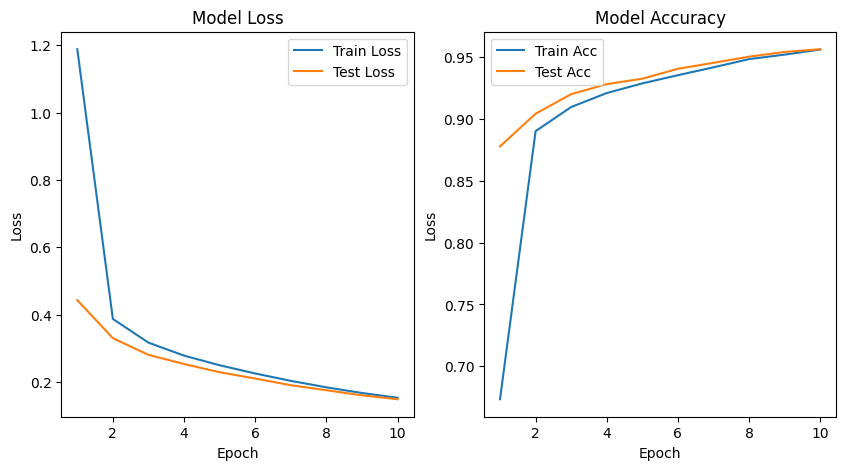

In [28]:
if not need_training:
    print("Notice: Model hasn't trained in this session!")

plot_train_history(history)

Predicted label: 1, True label: 1


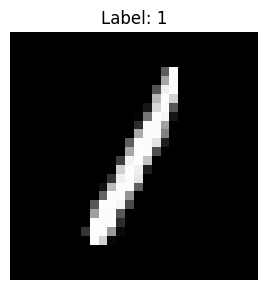

In [29]:
pred_random_sample(
    model=student,
    dataset=test_set
)

### How many samples predicted correct/wrong?

In [30]:
report_correct_incorrect(
    model=student,
    dataset=test_set
)

Number of correctly predicted samples: 9562
Number of incorrectly predicted samples: 438
Model's accuracy: 95.620%


In [31]:
student_train_acc_list = history["train acc"]
student_test_acc_list = history["test acc"]

# Knowledge Distillation

## Prepare data using Teacher model

In [32]:
train_set_logit = []

with torch.no_grad():
    for image, label in train_set:
        logits = teacher(image)
        train_set_logit.append((image, logits.squeeze(), label))

## Training config

In [33]:
KD_LearningRare = 1e-2
KD_BATCH_SIZE = 32
KD_EPOCHS = 10

KD_LOSS_F = nn.MSELoss()
KD_Optimizer_GEN = torch.optim.SGD

## Train KD Model

In [34]:
model_path = os.path.join(BASE_PATH, "knowledge_distillation_model.pth")
history_path = os.path.join(BASE_PATH, "knowledge_distillation_history.npy")
knowledge_distillation = Student()
need_training = True

if os.path.exists(model_path) and os.path.exists(history_path):
    print(f"Loading model from {model_path}")
    knowledge_distillation.load_state_dict(torch.load(model_path))
    history = np.load(history_path, allow_pickle=True).item()
    need_training = False

Loading model from question4/knowledge_distillation_model.pth


In [35]:
if need_training:
    history = train_model(
        model=knowledge_distillation,
        batch_size=KD_BATCH_SIZE,
        loss_function=KD_LOSS_F,
        optimizer_gen=KD_Optimizer_GEN,
        learning_rate=KD_LearningRare,
        epochs=KD_EPOCHS,
        train_set=train_set_logit,
        test_set=test_set,
        triple_format=True,
    )

    torch.save(knowledge_distillation.state_dict(), model_path)
    np.save(history_path, history, allow_pickle=True)
else:
    print(f"Model has been trained already!")

Model has been trained already!


Notice: Model hasn't trained in this session!


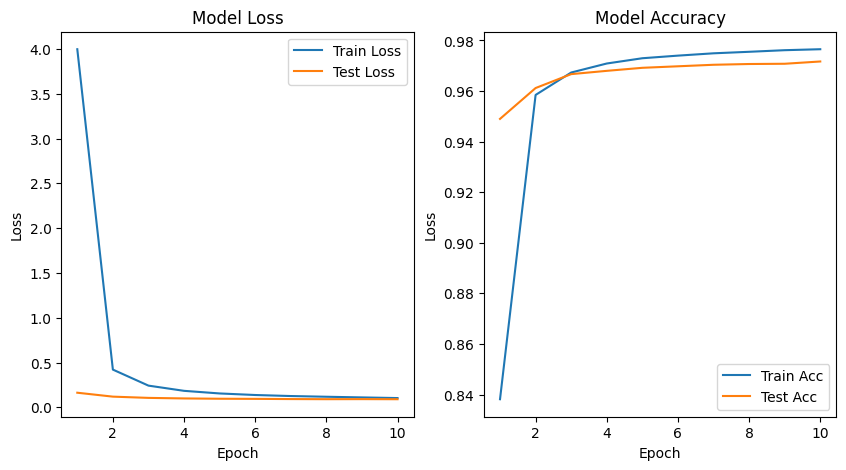

In [36]:
if not need_training:
    print("Notice: Model hasn't trained in this session!")

plot_train_history(history)

Predicted label: 3, True label: 3


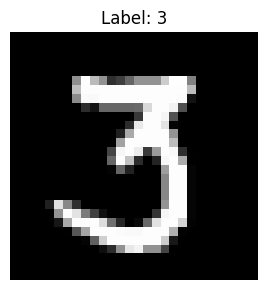

In [37]:
pred_random_sample(
    model=knowledge_distillation,
    dataset=test_set
)

In [38]:
report_correct_incorrect(
    model=knowledge_distillation,
    dataset=test_set
)

Number of correctly predicted samples: 9717
Number of incorrectly predicted samples: 283
Model's accuracy: 97.170%


In [39]:
kd_train_acc_list = history["train acc"]
kd_test_acc_list = history["test acc"]

## Knowledge Distillation vs. Regular Training

In [40]:
print("STUDENT MODEL ::: Regular Training")
report_correct_incorrect(
    model=student,
    dataset=test_set
)

print("*-----------------------*-----------------------*")

print("KD MODEL ::: Knowledge Distillation")
report_correct_incorrect(
    model=knowledge_distillation,
    dataset=test_set
)

STUDENT MODEL ::: Regular Training
Number of correctly predicted samples: 9562
Number of incorrectly predicted samples: 438
Model's accuracy: 95.620%
*-----------------------*-----------------------*
KD MODEL ::: Knowledge Distillation
Number of correctly predicted samples: 9717
Number of incorrectly predicted samples: 283
Model's accuracy: 97.170%


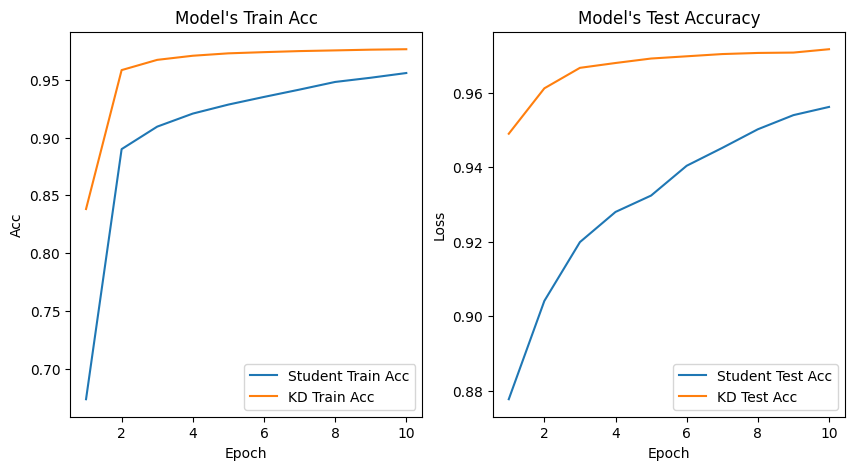

In [41]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(student_train_acc_list)+1), student_train_acc_list, label='Student Train Acc')
plt.plot(range(1, len(kd_train_acc_list)+1), kd_train_acc_list, label='KD Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title("Model's Train Acc")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(student_test_acc_list)+1), student_test_acc_list, label='Student Test Acc')
plt.plot(range(1, len(kd_test_acc_list)+1), kd_test_acc_list, label='KD Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Model's Test Accuracy")
plt.legend()
plt.show()